In [28]:
from sysconfig import get_python_version
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import csv

In [29]:
get_ipython().run_line_magic('matplotlib', 'inline')

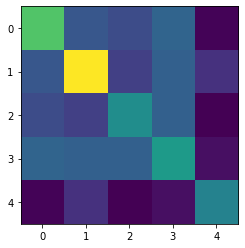

In [30]:
# set number of assets (= number of qubits)
num_assets = 5
seed = 1234

# Using data from yahoo finance
# use the name listed for particular company that you wish to add
data = YahooDataProvider(
        tickers=["AAPL","INTC","GOOG","MSFT","IBM"],
        start=datetime.datetime(2015, 9, 1),
        end=datetime.datetime(2021, 12, 1),
    )

data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

plt.imshow(sigma, interpolation="nearest")
plt.show()

In [31]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.0001698218211546148*x_0^2 + 0.000202269641204743..., 5 variables, 1 constraints, 'Portfolio optimization'>

In [32]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result,fname):
    
    f = open(fname, 'w')
    header = ['SELECTION', 'VALUE', 'PROBABLITY']
    writer = csv.writer(f)
    writer.writerow(header)
    
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        row = [x, value, probability]
        writer.writerow(row)
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))
    f.close()


In [33]:
#classical reference solution
#provide fname ='complete address/location of your .csv file'


exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)
fname = (r"C:\Users\shrey\Documents\results_qiskit.csv") 

#change the location and nsame of .csv file

print_result(result,fname)

Optimal: selection [1. 0. 0. 1. 0.], value -0.0023

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 0 1 0]	-0.0023		1.0000
[1 1 1 1 1]	9.0639		0.0000
[0 1 1 1 1]	4.0276		0.0000
[1 0 0 0 0]	1.0062		0.0000
[0 1 0 0 0]	1.0069		0.0000
[1 1 0 0 0]	-0.0014		0.0000
[0 0 1 0 0]	1.0064		0.0000
[1 0 1 0 0]	-0.0020		0.0000
[0 1 1 0 0]	-0.0012		0.0000
[1 1 1 0 0]	1.0053		0.0000
[0 0 0 1 0]	1.0060		0.0000
[0 1 0 1 0]	-0.0016		0.0000
[1 1 0 1 0]	1.0050		0.0000
[0 0 1 1 0]	-0.0021		0.0000
[1 0 1 1 0]	1.0045		0.0000
[0 1 1 1 0]	1.0052		0.0000
[1 1 1 1 0]	4.0266		0.0000
[0 0 0 0 1]	1.0073		0.0000
[1 0 0 0 1]	-0.0011		0.0000
[0 1 0 0 1]	-0.0003		0.0000
[1 1 0 0 1]	1.0061		0.0000
[0 0 1 0 1]	-0.0009		0.0000
[1 0 1 0 1]	1.0056		0.0000
[0 1 1 0 1]	1.0063		0.0000
[1 1 1 0 1]	4.0277		0.0000
[0 0 0 1 1]	-0.0013		0.0000
[1 0 0 1 1]	1.0052		0.0000
[0 1 0 1 1]	1.0060		0.0000
[1 1 0 1 1]	4.0274		0.0000
[0 0 1 1 1]	1.0054		0.

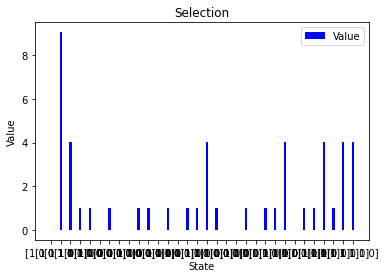

In [34]:
import matplotlib.pyplot as plt
import csv
  
x = []
y = []
  
with open(r'C:\Users\shrey\Documents\results.csv') as csvfile:
    plots = csv.reader(csvfile, delimiter = ',')
      
    for row in plots:
        x.append(row[0])
        y.append(float(row[1]))
  
plt.bar(x, y, color = 'b', width = 0.25, label = "Value")
plt.xlabel('State')
plt.ylabel('Value')
plt.title('Selection')
plt.legend()
plt.show()

In [ ]:
from typing import Optional
from scipy.optimize import minimize
#from .optimizer import Optimizer, OptimizerSupportLevel
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [36]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")


#COBYLA(maxiter=1000, disp=False, rhobeg=1.0, tol=None)

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

fname = (r'C:\Users\shrey\Documents\vqe1.csv') #change the location and name of .csv file
print_result(result, fname)



Optimal: selection [1. 0. 0. 1. 0.], value -0.0023

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 0 0 0]	-0.0014		0.4187
[1 0 0 1 0]	-0.0023		0.3852
[0 0 1 1 0]	-0.0021		0.0862
[0 1 1 0 0]	-0.0012		0.0833
[1 0 0 0 1]	-0.0011		0.0147
[0 0 0 1 1]	-0.0013		0.0043
[0 1 0 0 1]	-0.0003		0.0034
[0 0 1 0 1]	-0.0009		0.0030
[0 0 1 0 0]	1.0064		0.0002
[0 1 1 1 0]	1.0052		0.0002
[0 1 0 1 0]	-0.0016		0.0001
[0 1 0 0 0]	1.0069		0.0001
[0 1 1 0 1]	1.0063		0.0001
[1 0 0 1 1]	1.0052		0.0001
[0 0 1 1 1]	1.0054		0.0001
[0 0 0 1 0]	1.0060		0.0001
[1 0 1 0 1]	1.0056		0.0000
[1 1 0 1 0]	1.0050		0.0000
[1 0 0 0 0]	1.0062		0.0000
[0 0 0 0 1]	1.0073		0.0000
[1 0 1 0 0]	-0.0020		0.0000
[1 1 1 0 1]	4.0277		0.0000
[1 1 1 1 0]	4.0266		0.0000
[1 1 1 0 0]	1.0053		0.0000
[0 1 0 1 1]	1.0060		0.0000
[1 0 1 1 0]	1.0045		0.0000
[0 0 0 0 0]	4.0294		0.0000
[0 1 1 1 1]	4.0276		0.0000
[1 1 0 0 1]	1.0061		0.0000
[1 1 1 1 1]	9.0639		0.

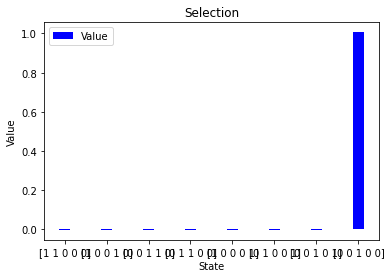

In [39]:
import matplotlib.pyplot as plt
import csv
  
x = []
y = []
  
with open(r'C:\Users\shrey\Documents\vqe1.csv') as csvfile:
    plots = csv.reader(csvfile, delimiter = ',')
      
    for row in plots:
        x.append(row[0])
        y.append(float(row[1]))
  
plt.bar(x, y, color = 'b', width = 0.25, label = "Value")
plt.xlabel('State')
plt.ylabel('Value')
plt.title('Selection')
plt.legend()
plt.show()

In [41]:
#### QAOA solution

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

fname = (r'C:\Users\shrey\Documents\qaoa1.csv') #change the location and name of .csv file
print_result(result, fname)

Optimal: selection [1. 0. 0. 1. 0.], value -0.0023

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 1]	-0.0003		0.0983
[0 0 1 0 1]	-0.0009		0.0982
[1 0 0 0 1]	-0.0011		0.0982
[0 1 1 0 0]	-0.0012		0.0981
[0 0 0 1 1]	-0.0013		0.0981
[1 1 0 0 0]	-0.0014		0.0981
[0 1 0 1 0]	-0.0016		0.0981
[1 0 1 0 0]	-0.0020		0.0980
[0 0 1 1 0]	-0.0021		0.0980
[1 0 0 1 0]	-0.0023		0.0980
[0 0 0 0 0]	4.0294		0.0038
[1 0 1 1 0]	1.0045		0.0011
[1 1 0 1 0]	1.0050		0.0011
[0 1 1 1 0]	1.0052		0.0011
[1 0 0 1 1]	1.0052		0.0011
[1 1 1 0 0]	1.0053		0.0011
[0 0 1 1 1]	1.0054		0.0011
[1 0 1 0 1]	1.0056		0.0011
[0 1 0 1 1]	1.0060		0.0011
[1 1 0 0 1]	1.0061		0.0011
[0 1 1 0 1]	1.0063		0.0011
[1 1 1 1 1]	9.0639		0.0010
[0 0 0 1 0]	1.0060		0.0006
[1 0 0 0 0]	1.0062		0.0006
[0 0 1 0 0]	1.0064		0.0006
[0 1 0 0 0]	1.0069		0.0005
[0 0 0 0 1]	1.0073		0.0005
[1 1 1 1 0]	4.0266		0.0001
[1 0 1 1 1]	4.0268		0.0001
[1 1 0 1 1]	4.0274		0.

In [ ]:
import matplotlib.pyplot as plt
import csv
  
x = []
y = []
  
with open(r'C:\Users\shrey\Documents\qaoa1.csv') as csvfile:
    plots = csv.reader(csvfile, delimiter = ',')
      
    for row in plots:
        x.append(row[0])
        y.append(float(row[1]))
  
plt.bar(x, y, color = 'b', width = 0.25, label = "Value")
plt.xlabel('State')
plt.ylabel('Value')
plt.title('Selection')
plt.legend()
plt.show()

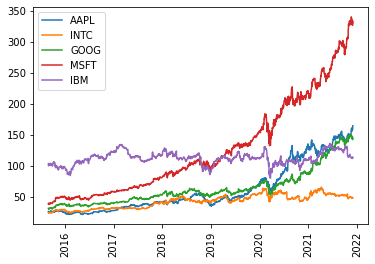

In [43]:
#plotting the stock trend

stocks = ["COST","AMZN","TGT","WMT"]

token = "NBQ7j3g_Q8_bcpvW6kMA"
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    try:
        wiki = WikipediaDataProvider(
            token=token,
            tickers=stocks,
            start=datetime.datetime(2016, 1, 1),
            end=datetime.datetime(2017, 12, 31),
        )
        wiki.run()
    except QiskitFinanceError as ex:
        print(ex)
        print("Error retrieving data.")


if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        if wiki._n <= 1:
            print(
                "Not enough wiki data to plot covariance or time-series similarity. Please use at least two tickers."
            )
        else:
            rho = wiki.get_similarity_matrix()
            print("A time-series similarity measure:")
            print(rho)
            plt.imshow(rho)
            plt.show()

            cov = wiki.get_covariance_matrix()
            print("A covariance matrix:")
            print(cov)
            plt.imshow(cov)
            plt.show()
    else:
        print("No wiki data loaded.")

if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        print("The underlying evolution of stock prices:")
        for (cnt, s) in enumerate(stocks):
            plt.plot(wiki._data[cnt], label=s)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

        for (cnt, s) in enumerate(stocks):
            print(s)
            print(wiki._data[cnt])
    else:
        print("No wiki data loaded.")

for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.show()